In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

### Load model

In [2]:
from in_silico.model.mlflow_loader import ModelPaths, DataPaths, load_free_viewing_model_from_mlflow

model_paths = ModelPaths(
    checkpoint_uri="mlflow-artifacts:/621818231566971674/2f85fd6f5dda46e280456d3186618e1c/artifacts/6806be20120f307fa684cd4c637ad949_final.pth.tar",
    config_uri="mlflow-artifacts:/621818231566971674/2f85fd6f5dda46e280456d3186618e1c/artifacts/6806be20120f307fa684cd4c637ad949_final_cfg.pth.tar",
)
data_paths = DataPaths(session_dirs=["/mnt/data1/enigma/goliath_10_20_sandbox/37_3843837605846_0_V3A_V4/"])

out = load_free_viewing_model_from_mlflow(
    model_paths,
    data_paths,
    cuda_visible_devices="9",
    mlflow_tracking_uri="https://mlflow.enigmatic.stanford.edu/",
    mlflow_username="mlflow-runner",
    mlflow_password="x3i#U9*73N75",
)

Skipping import of cpp extensions due to incompatible torch version 2.7.0a0+7c8ec84dab.nv25.03 for torchao version 0.16.0             Please see https://github.com/pytorch/ao/issues/2919 for more info


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Dataset 0: 37_3843837605846_0_V3A_V4, length = 215312
Sessions: ['37_3843837605846_0_V3A_V4']
Batches per session: {'37_3843837605846_0_V3A_V4': 26914}
Total batches: 26914
Created FastSessionDataLoader with 1 sessions and 26914 total batches
Dataset 0: 37_3843837605846_0_V3A_V4, length = 22977
Sessions: ['37_3843837605846_0_V3A_V4']
Batches per session: {'37_3843837605846_0_V3A_V4': 2872}
Total batches: 2872
Created FastSessionDataLoader with 1 sessions and 2872 total batches


In [3]:
from in_silico.model.wrapper import ModelWrapper

# out is the tuple returned by load_free_viewing_model_from_mlflow(...)
model, skip_samples, cfg, extra = out   # <-- now cfg exists

# pick skip_samples: prefer the returned value if it exists
# (some codebases return it explicitly, and cfg may or may not have it)
if skip_samples is None:
    skip_samples = cfg.trainer.skip_n_samples

wrapper = ModelWrapper(model, skip_samples=skip_samples)

### Load indices

In [4]:
indices_v3a = np.load('/workdir/analysis_parametric/indices_v3a.npy')

### Create stimulus

In [5]:
from in_silico.stimuli.sparse_noise import SparseNoiseSpec, make_sparse_noise

In [89]:
spec = SparseNoiseSpec(
    num_samples=12,
    dot_offset_samples=3,
    dot_duration_samples=6,
    fps=30.0,
    square_size_px = 100,
    dots_per_frame = 1,
    seed= 2094
)

frames, ts, events = make_sparse_noise(spec)

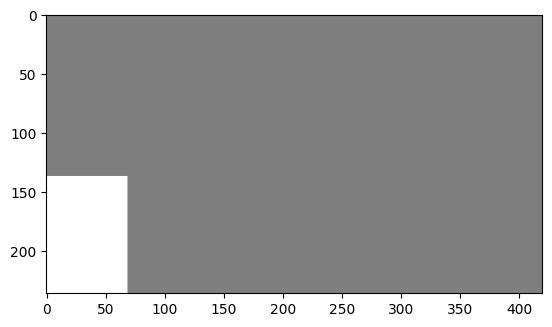

In [90]:
plt.imshow(frames[4].transpose((1,2,0)))

### Predict responses

In [72]:
from in_silico.model.wrapper import ModelWrapper

wrapper = ModelWrapper(
    model,
    key='37_3843837605846_0_V3A_V4',  # whatever `key` variable you used (often "screen")
    skip_samples=skip_samples,
    amp=cfg.trainer.amp,
)

from in_silico.analyses.normalize_input import normalize_input
frames_norm = normalize_input(frames)

pred, info = wrapper.predict(frames_norm)  # gaze defaults to zeros, gaze_time defaults to 3600
print(info)
print(pred.shape)  # (units, T_valid)

{'skip_samples': 3, 'T': 12, 'T_valid': 9, 'gaze_time': 3600.0, 'pred_full_shape': (653, 12)}
(653, 9)


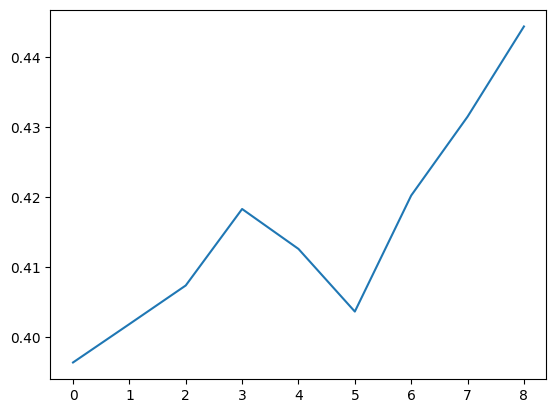

In [78]:
plt.plot(pred[indices_v3a].mean(0))

In [23]:
indices_v3a

array([ 25,  26,  30,  32,  33,  37,  38,  41,  44,  46,  48,  50,  52,
        53,  54,  57,  60,  61,  62,  83,  84,  86,  87,  88,  89,  93,
        94,  95,  99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 115, 116, 118, 121, 123, 127, 137, 144, 145, 166, 189,
       228, 230, 236, 242, 327, 333, 339, 340, 345, 354, 371, 377, 379,
       384, 387, 392, 398, 422, 423, 424, 425, 429, 430, 441, 443, 447,
       454, 458, 459, 468, 478, 488, 496, 521, 525, 532, 533, 535])